### Conducting basic NLP on sentence and segment level text

In [17]:
SEED = 1

import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

PATH_SENTENCE_TEXT = r"../dataset/concat_sentence_text.csv"
PATH_SEGMENT_TEXT = r"../dataset/concat_segment_text.csv"

## Part 1: NLP on sentence level text

In [2]:
df = pd.read_csv(PATH_SENTENCE_TEXT)
df.head()

,sentence_text,practice,modality
0,"IP ADDRESS, COOKIES, AND WEB BEACONS",Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED
1,"IP ADDRESS, COOKIES, AND WEB BEACONS",Identifier_IP_Address_1stParty,PERFORMED
2,"IP addresses will be collected, along with inf...",Identifier_IP_Address_1stParty,PERFORMED
3,The information that our products collect incl...,Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED
4,The information that our products collect incl...,Identifier_IP_Address_1stParty,PERFORMED


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18829 entries, 0 to 18828
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentence_text  18829 non-null  object
 1   practice       18829 non-null  object
 2   modality       18829 non-null  object
dtypes: object(3)
memory usage: 441.4+ KB


In [4]:
df["sentence_text"] = df["sentence_text"].astype("string")
df["practice"] = df["practice"].astype("category")
df["practice"] = df["practice"].astype("category")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18829 entries, 0 to 18828
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   sentence_text  18829 non-null  string  
 1   practice       18829 non-null  category
 2   modality       18829 non-null  object  
dtypes: category(1), object(1), string(1)
memory usage: 315.2+ KB


In [9]:
# Save counts into a dataframe
df_value_counts = df["practice"].value_counts().rename_axis("practice").reset_index(name = "counts")
df_value_counts.head(10)

,practice,counts
0,Identifier_Cookie_or_similar_Tech_1stParty,2107
1,Contact_E_Mail_Address_1stParty,2106
2,Location_1stParty,1514
3,Identifier_Cookie_or_similar_Tech_3rdParty,1250
4,Identifier_IP_Address_1stParty,1005
5,Contact_Phone_Number_1stParty,970
6,Identifier_Device_ID_1stParty,697
7,Contact_Postal_Address_1stParty,597
8,SSO,504
9,Demographic_Age_1stParty,428


In [12]:
## Limit to top 5 categories
top_5_cats = list(df_value_counts["practice"][:5])

df = df[df["practice"].isin(top_5_cats)]
df.head()

,sentence_text,practice,modality
0,"IP ADDRESS, COOKIES, AND WEB BEACONS",Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED
1,"IP ADDRESS, COOKIES, AND WEB BEACONS",Identifier_IP_Address_1stParty,PERFORMED
2,"IP addresses will be collected, along with inf...",Identifier_IP_Address_1stParty,PERFORMED
3,The information that our products collect incl...,Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED
4,The information that our products collect incl...,Identifier_IP_Address_1stParty,PERFORMED


In [63]:
vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1,4), strip_accents='ascii', binary = True)
tfidf_vectors = vectorizer.fit_transform(df["sentence_text"])

In [14]:
# Sanity check: Number of rows in matrix same as number of sentences.
# We have 51747 unique tokens after tokenisation
print(len(df))
print(tfidf_vectors.shape)

7982
(7982, 218540)


In [16]:
# Train test split, 20% test size?
x_train, x_test, y_train, y_test = train_test_split(tfidf_vectors, df["practice"], test_size = 0.2, random_state = SEED)

## Testing with logistic regression

In [17]:
logistic_clf = LogisticRegression(random_state = SEED, max_iter = 500, n_jobs = -1, multi_class = "ovr").fit(x_train, y_train)
y_pred = logistic_clf.predict(x_test)

In [18]:
print(classification_report(y_test, y_pred))

                                            precision    recall  f1-score   support

           Contact_E_Mail_Address_1stParty       0.66      0.85      0.74       413
Identifier_Cookie_or_similar_Tech_1stParty       0.54      0.70      0.61       418
Identifier_Cookie_or_similar_Tech_3rdParty       0.47      0.30      0.37       238
            Identifier_IP_Address_1stParty       0.56      0.37      0.45       214
                         Location_1stParty       0.60      0.45      0.52       314

                                  accuracy                           0.59      1597
                                 macro avg       0.57      0.53      0.54      1597
                              weighted avg       0.58      0.59      0.57      1597



## Testing with SGDClassifier

In [20]:
clf_sgdclassifier = SGDClassifier(loss = "hinge", max_iter = 5000, random_state=SEED, n_jobs = -1).fit(x_train, y_train)
y_pred = clf_sgdclassifier.predict(x_test)

In [21]:
print(classification_report(y_test, y_pred))

                                            precision    recall  f1-score   support

           Contact_E_Mail_Address_1stParty       0.70      0.80      0.75       413
Identifier_Cookie_or_similar_Tech_1stParty       0.54      0.59      0.56       418
Identifier_Cookie_or_similar_Tech_3rdParty       0.41      0.38      0.39       238
            Identifier_IP_Address_1stParty       0.47      0.36      0.41       214
                         Location_1stParty       0.56      0.53      0.54       314

                                  accuracy                           0.57      1597
                                 macro avg       0.54      0.53      0.53      1597
                              weighted avg       0.56      0.57      0.56      1597



## Testing with LinearSVC (used by the original authors)

In [23]:
linearSVC_clf = SVC(kernel= "linear", class_weight="balanced").fit(x_train, y_train)
y_pred = linearSVC_clf.predict(x_test)

In [24]:
print(classification_report(y_test, y_pred))

                                            precision    recall  f1-score   support

           Contact_E_Mail_Address_1stParty       0.76      0.77      0.76       413
Identifier_Cookie_or_similar_Tech_1stParty       0.59      0.57      0.58       418
Identifier_Cookie_or_similar_Tech_3rdParty       0.43      0.45      0.44       238
            Identifier_IP_Address_1stParty       0.46      0.48      0.47       214
                         Location_1stParty       0.58      0.55      0.56       314

                                  accuracy                           0.59      1597
                                 macro avg       0.56      0.56      0.56      1597
                              weighted avg       0.59      0.59      0.59      1597



### Random forests

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
# clf_randomforest = RandomForestClassifier(n_jobs = -1, random_state = SEED).fit(x_train, y_train)
# y_pred = clf_randomforest.predict(x_test)

In [27]:
print(classification_report(y_test, y_pred))

                                            precision    recall  f1-score   support

           Contact_E_Mail_Address_1stParty       0.65      0.75      0.70       413
Identifier_Cookie_or_similar_Tech_1stParty       0.48      0.57      0.52       418
Identifier_Cookie_or_similar_Tech_3rdParty       0.37      0.30      0.33       238
            Identifier_IP_Address_1stParty       0.44      0.34      0.38       214
                         Location_1stParty       0.52      0.44      0.48       314

                                  accuracy                           0.52      1597
                                 macro avg       0.49      0.48      0.48      1597
                              weighted avg       0.51      0.52      0.51      1597



### Summary (29/8/22): Trying different models using Tfidf yields low performance. 
The issue should be with feature engineering. Need to look at word embeddings first perhaps, before looking at what models to use.

TODO: How does this affect interpret package usage?

### Summary (3/9/22): Tried BERT both on all categories and on top 5 categories. Both yield low performance. 
Might be because not enough training data to train all the parameters.

Non-neural networks yield better performance out of the box. 
So stick to linear models, but at the same time figure out to limit to which categories to predict? 

### Boosting classifiers

In [32]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

#### AdaBoost default (uses decision tree as base classifier)
Tried with SVC, took too long to train and results were very poor.

Decision tree classifiers seem to take very long to train on the dataset. About 8m? As seen below

In [33]:
clf_ada_boost = AdaBoostClassifier(DecisionTreeClassifier(), random_state=SEED).fit(x_train, y_train)
y_pred = clf_ada_boost.predict(x_test)

In [34]:
print(classification_report(y_test, y_pred))

'                                            precision    recall  f1-score   support\n\n           Contact_E_Mail_Address_1stParty       0.59      0.71      0.65       413\nIdentifier_Cookie_or_similar_Tech_1stParty       0.45      0.47      0.46       418\nIdentifier_Cookie_or_similar_Tech_3rdParty       0.31      0.30      0.31       238\n            Identifier_IP_Address_1stParty       0.42      0.29      0.34       214\n                         Location_1stParty       0.48      0.44      0.46       314\n\n                                  accuracy                           0.48      1597\n                                 macro avg       0.45      0.44      0.44      1597\n                              weighted avg       0.47      0.48      0.47      1597\n'

#### AdaBoost with logistic regression as base classifier

In [37]:
clf_ada_boost = AdaBoostClassifier(LogisticRegression(random_state = SEED, max_iter = 500, n_jobs = -1, multi_class = "ovr"), random_state=SEED, n_estimators=200).fit(x_train, y_train)
y_pred = clf_ada_boost.predict(x_test)

In [38]:
print(classification_report(y_test, y_pred))

                                            precision    recall  f1-score   support

           Contact_E_Mail_Address_1stParty       0.61      0.76      0.68       413
Identifier_Cookie_or_similar_Tech_1stParty       0.37      0.97      0.54       418
Identifier_Cookie_or_similar_Tech_3rdParty       0.00      0.00      0.00       238
            Identifier_IP_Address_1stParty       1.00      0.01      0.02       214
                         Location_1stParty       1.00      0.01      0.01       314

                                  accuracy                           0.45      1597
                                 macro avg       0.60      0.35      0.25      1597
                              weighted avg       0.59      0.45      0.32      1597



c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [44]:
classification_report(y_test, y_pred, output_dict=True)

c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

{'Contact_E_Mail_Address_1stParty': {'precision': 0.6140350877192983,
  'recall': 0.7627118644067796,
  'f1-score': 0.6803455723542118,
  'support': 413},
 'Identifier_Cookie_or_similar_Tech_1stParty': {'precision': 0.37407407407407406,
  'recall': 0.9665071770334929,
  'f1-score': 0.5393858477970627,
  'support': 418},
 'Identifier_Cookie_or_similar_Tech_3rdParty': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 238},
 'Identifier_IP_Address_1stParty': {'precision': 1.0,
  'recall': 0.009345794392523364,
  'f1-score': 0.018518518518518517,
  'support': 214},
 'Location_1stParty': {'precision': 1.0,
  'recall': 0.006369426751592357,
  'f1-score': 0.012658227848101266,
  'support': 314},
 'accuracy': 0.45272385723231057,
 'macro avg': {'precision': 0.5976218323586744,
  'recall': 0.34898685251687767,
  'f1-score': 0.2501816333035789,
  'support': 1597},
 'weighted avg': {'precision': 0.5873258949223752,
  'recall': 0.45272385723231057,
  'f1-score': 0.322093708371151

### Testing performance with the top n practices (from top 3 - 8)
Using logistic regression, SGDClassifier, linearSVC

LinearSVC seems to give the most balanced performance (i.e in the sense of recall and precision) across the top N categories.

In [13]:
def testing_top_n() :
    
    results_dict = {"N" : [], "clf" : [], "report" : []}

    for n in range(3, 11) :

        print("Training for " + str(n))
        # iterate through the top n practices
        top_n_practice = list(df_value_counts["practice"][:n])
        df_subset = df[df["practice"].isin(top_n_practice)]
        
        # Vectorize and split training and test sets
        vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1,4), strip_accents='ascii', binary = True)
        tfidf_vectors = vectorizer.fit_transform(df_subset["sentence_text"])
        x_train, x_test, y_train, y_test = train_test_split(tfidf_vectors, df_subset["practice"], test_size = 0.2, random_state = SEED)
        
        # Fit classifiers
        print("Fitting logistic...")
        logistic_clf = LogisticRegression(random_state = SEED, max_iter = 500, n_jobs = -1, multi_class = "ovr").fit(x_train, y_train)
        y_pred = logistic_clf.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [logistic_clf]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Fitting SGDClassifier...")
        clf_sgdclassifier = SGDClassifier(loss = "hinge", max_iter = 5000, random_state=SEED, n_jobs = -1).fit(x_train, y_train)
        y_pred = clf_sgdclassifier.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [clf_sgdclassifier]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Fitting SVC...")
        linearSVC_clf = SVC(kernel= "linear", class_weight="balanced").fit(x_train, y_train)
        y_pred = linearSVC_clf.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [linearSVC_clf]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Training done " + str(n))

    return results_dict
        

In [12]:
df = pd.read_csv(PATH_SENTENCE_TEXT)

# Save counts into a dataframe
df_value_counts = df["practice"].value_counts().rename_axis("practice").reset_index(name = "counts")
df_value_counts.head(10)

,practice,counts
0,Identifier_Cookie_or_similar_Tech_1stParty,2107
1,Contact_E_Mail_Address_1stParty,2106
2,Location_1stParty,1514
3,Identifier_Cookie_or_similar_Tech_3rdParty,1250
4,Identifier_IP_Address_1stParty,1005
5,Contact_Phone_Number_1stParty,970
6,Identifier_Device_ID_1stParty,697
7,Contact_Postal_Address_1stParty,597
8,SSO,504
9,Demographic_Age_1stParty,428


In [14]:
results_dict = testing_top_n()

Training for 3
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 3
Training for 4
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 4
Training for 5
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 5
Training for 6
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 6
Training for 7
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 7
Training for 8
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 8
Training for 9
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 9
Training for 10
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 10


In [16]:
df_results = pd.DataFrame(results_dict)

df_results.head()

,N,clf,report
0,3,"LogisticRegression(max_iter=500, multi_class='...",{'Contact_E_Mail_Address_1stParty': {'precisio...
1,3,"SGDClassifier(max_iter=5000, n_jobs=-1, random...",{'Contact_E_Mail_Address_1stParty': {'precisio...
2,3,"SVC(class_weight='balanced', kernel='linear')",{'Contact_E_Mail_Address_1stParty': {'precisio...
3,4,"LogisticRegression(max_iter=500, multi_class='...",{'Contact_E_Mail_Address_1stParty': {'precisio...
4,4,"SGDClassifier(max_iter=5000, n_jobs=-1, random...",{'Contact_E_Mail_Address_1stParty': {'precisio...


In [20]:
def visualise_results(clf_report) :
    return sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot = True)

<AxesSubplot:>

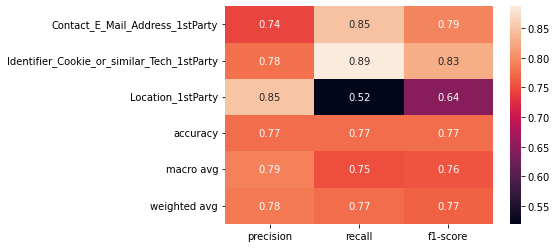

In [31]:
# Where N = 3, logistic regression
visualise_results(df_results.loc[df_results["N"] == 3]["report"].iloc[0])

<AxesSubplot:>

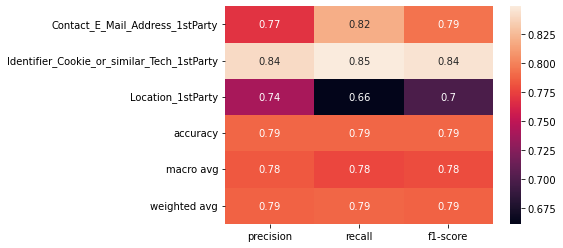

In [34]:
# Where N = 3, SVC
visualise_results(df_results.loc[df_results["N"] == 3]["report"].iloc[2])

<AxesSubplot:>

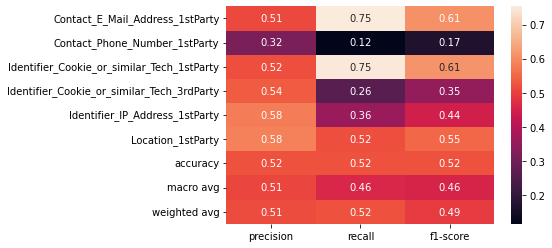

In [33]:
# Where N = 6, logistic regression
visualise_results(df_results.loc[df_results["N"] == 6]["report"].iloc[0])

<AxesSubplot:>

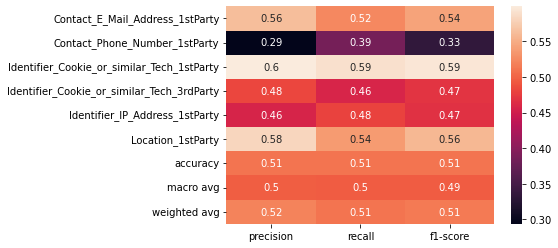

In [37]:
# Where N = 6, SVC
visualise_results(df_results.loc[df_results["N"] == 6]["report"].iloc[2])

<AxesSubplot:>

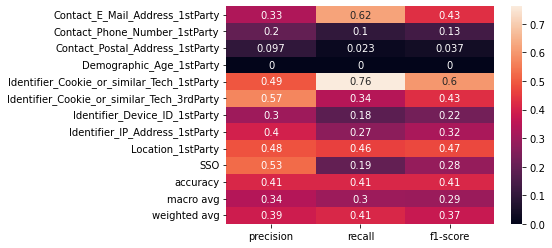

In [32]:
# Where N = 10, logistic regression
visualise_results(df_results.loc[df_results["N"] == 10]["report"].iloc[0])

<AxesSubplot:>

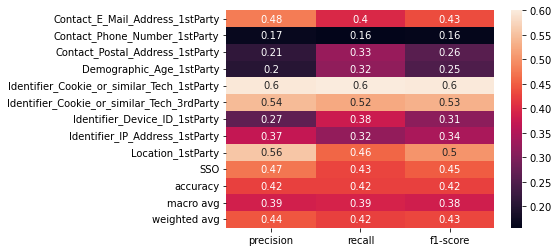

In [36]:
# Where N = 10, SVC
visualise_results(df_results.loc[df_results["N"] == 10]["report"].iloc[2])

### Visualise by grouped barchart, 
By weighted avg, as we have different support across the different classes

In [57]:
weighted_avg_dict = {"precision" : [], "recall" : [], "f1" : [], "support" : []}

for row in df_results.itertuples(index = False) :
    weighted_avg_dict["precision"] += [row[2]["weighted avg"]["precision"]]
    weighted_avg_dict["recall"] += [row[2]["weighted avg"]["recall"]]
    weighted_avg_dict["f1"] += [row[2]["weighted avg"]["f1-score"]]
    weighted_avg_dict["support"] += [row[2]["weighted avg"]["support"]]

In [58]:
df_results_weighted_avg = pd.DataFrame(
    {"N" : df_results["N"],
    "clf" : ["logistic", "sgd_classifier", "svc"] * 8,
    "precision" : weighted_avg_dict["precision"],
    "recall" : weighted_avg_dict["recall"],
    "f1" : weighted_avg_dict["f1"],
    "support" : weighted_avg_dict["support"]}
)

df_results_weighted_avg.head()

,N,clf,precision,recall,f1,support
0,3,logistic,0.784020,0.774869,0.766348,1146
1,3,sgd_classifier,0.778056,0.777487,0.774011,1146
2,3,svc,0.786877,0.787958,0.786539,1146
3,4,logistic,0.693727,0.690544,0.680007,1396
4,4,sgd_classifier,0.657406,0.658309,0.656638,1396


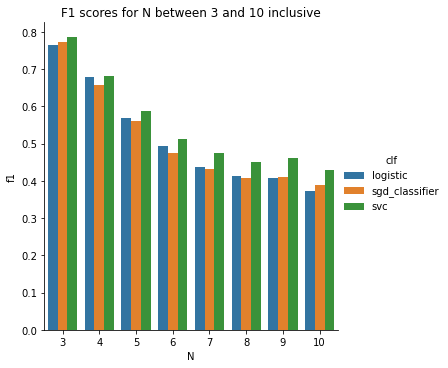

In [60]:
g = sns.catplot(data = df_results_weighted_avg, kind = "bar", x = "N", y = "f1", hue = "clf").set(title = "F1 scores (weighted avg) for N between 3 and 10 inclusive")

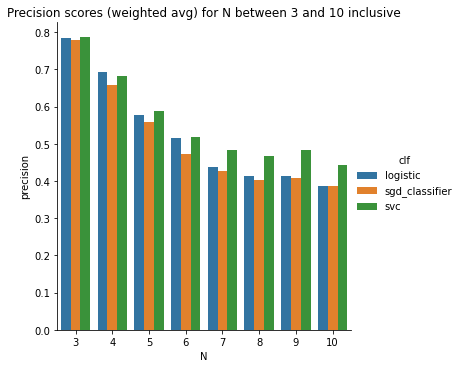

In [61]:
g = sns.catplot(data = df_results_weighted_avg, kind = "bar", x = "N", y = "precision", hue = "clf").set(title = "Precision scores (weighted avg) for N between 3 and 10 inclusive")

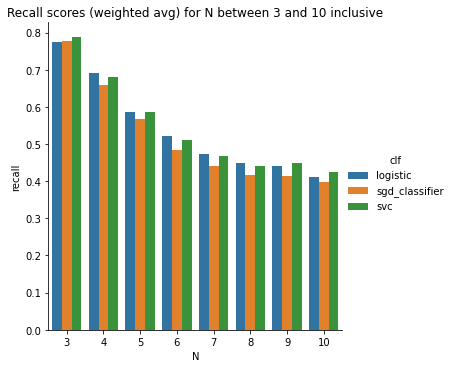

In [62]:
g = sns.catplot(data = df_results_weighted_avg, kind = "bar", x = "N", y = "recall", hue = "clf").set(title = "Recall scores (weighted avg) for N between 3 and 10 inclusive")